In [1]:
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr

from statsmodels.regression.linear_model import OLS

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
plt.rcParams["figure.autolayout"] = True
plt.rcParams['figure.dpi'] = 100
sns.set_style("darkgrid")

In [3]:
random_seed = 1923
rng = np.random.default_rng(random_seed)

## Data generation

In [4]:
# Predictor
n_obs = 100
x_mean = 10
x_sd = 2
x = rng.normal(x_mean, x_sd, n_obs)
xarray = xr.DataArray(x, dims = ["plot_dim"])

# Relationship & link function
true_intercept = 0.1 # Value of log(y) when X is zero
true_slope = 0.25 # Change in log(y) when X changes by 1. The relationship becomes very strong towards 0.5, weak towards 0.2
true_line = np.exp(true_intercept + (true_slope * x)) # Conditional mean as a function of the linear predictor with log link.

# Target
y = rng.poisson(lam = true_line, size = n_obs) # N. of events as a function of the conditional mean. Mean = variance = rate (lambda).
noise = y - true_line # Variance in number of events

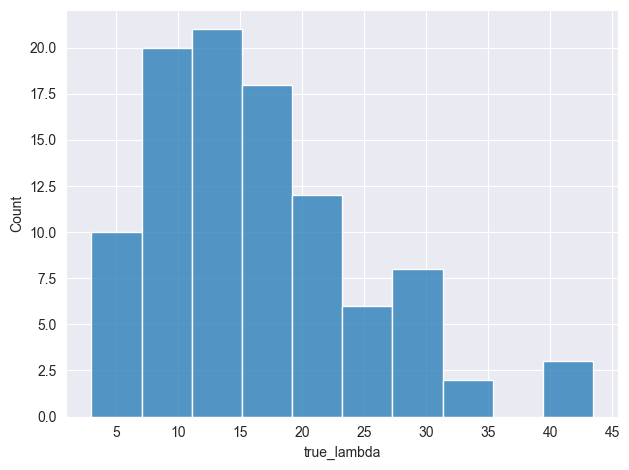

In [5]:
# Distribution of lambda parameters. Higher rate = higher expected n. of events = higher variance in n. of events.
_ = sns.histplot(true_line)
_ = plt.xlabel("true_lambda")

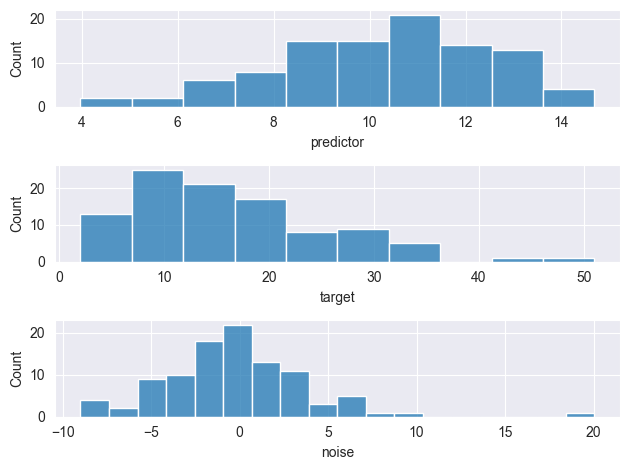

In [6]:
# Distributions of data
fig, ax = plt.subplots(3)

_ = sns.histplot(x, ax = ax[0])
_ = ax[0].set_xlabel("predictor")

_ = sns.histplot(y, ax = ax[1])
_ = ax[1].set_xlabel("target")

_ = sns.histplot(noise, ax = ax[2])
_ = ax[2].set_xlabel("noise")

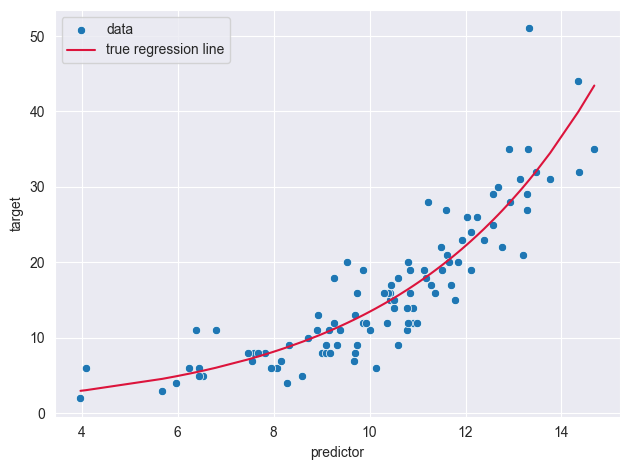

In [7]:
# True regression line
_ = sns.scatterplot(x = x, y = y, label = "data")
_ = sns.lineplot(x = x, y = true_line, label = "true regression line", color = "crimson")
_ = plt.xlabel("predictor")
_ = plt.ylabel("target")

Higher x slope means higher rate, lower variance relationship between x and y, larger & more broad range of y values.

Higher intercept means higher rate, lower variance relationship between x and y, larger & broad range of y values.

## Frequentist OLS

In [8]:
constant = np.ones(n_obs)
exog = np.stack([x, constant]).transpose()

In [9]:
ols = OLS(endog = np.log(y), exog = exog)

In [10]:
ols_res = ols.fit()
ols_fitted = np.exp(ols.predict(ols_res.params, exog))

In [11]:
ols_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     396.2
Date:                Wed, 17 Jan 2024   Prob (F-statistic):           3.32e-36
Time:                        11:22:55   Log-Likelihood:                -12.942
No. Observations:                 100   AIC:                             29.88
Df Residuals:                      98   BIC:                             35.09
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2486      0.012     19.904      0.000       0.224       0.273
const          0.0650      0.131      0.497      0.620      -0.195       0.325
==============================================================================
Omnibus:                        3.192   Durbin-Watson:                   1.828
Prob(Omnibus):                  0.203   Jarque-Bera (JB):                3.349
Skew:                           0.025   Prob(JB):                        0.187
Kurtosis:                       3.895   Cond. No.                         49.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

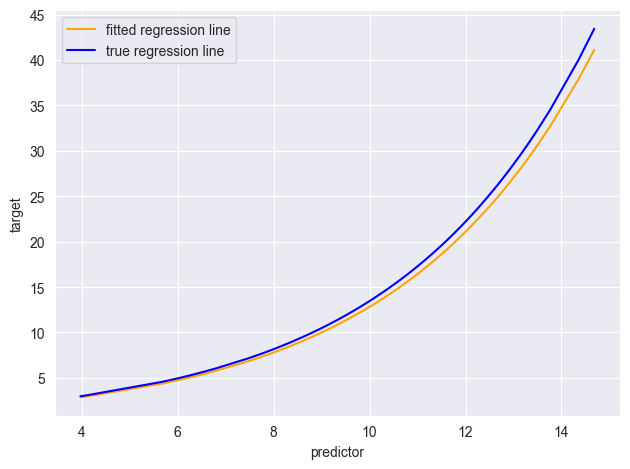

In [12]:
_ = sns.lineplot(
    x = x, 
    y = ols_fitted, 
    label = "fitted regression line", color = "orange")
_ = sns.lineplot(
    x = x, 
    y = true_line, 
    label = "true regression line", color = "blue")
_ = plt.xlabel("predictor")
_ = plt.ylabel("target")

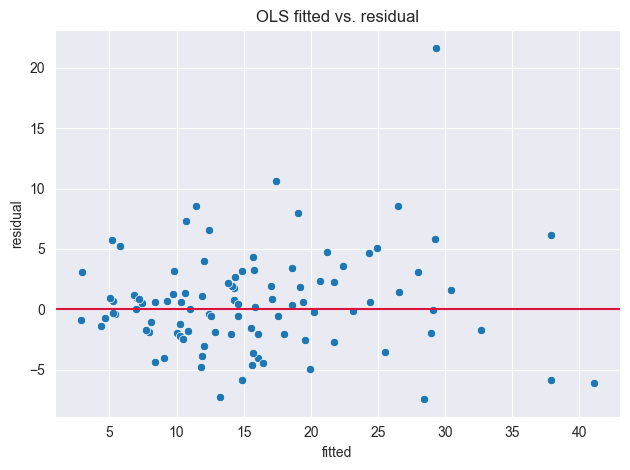

In [13]:
ols_resids = y - ols_fitted
_ = sns.scatterplot(x = ols_fitted, y = ols_resids)
_ = plt.axhline(0, c = "crimson")
_ = plt.title("OLS fitted vs. residual")
_ = plt.xlabel("fitted")
_ = plt.ylabel("residual")

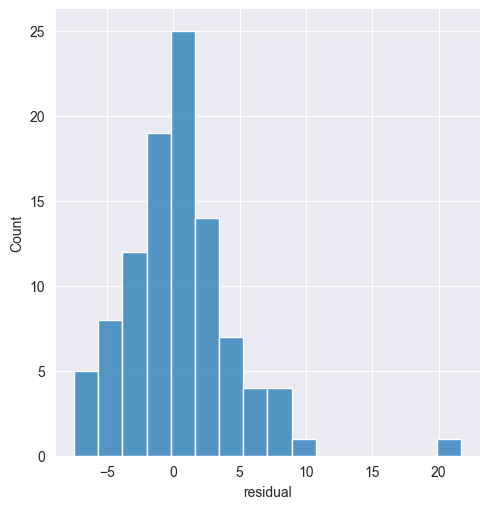

In [14]:
_ = sns.displot(ols_resids)
_ = plt.xlabel("residual")

Decent estimate of the true slope, but struggles with the intercept & the unequal variance in errors.

## Flat prior

In [15]:
# Create model
flat_model = pm.Model()

In [16]:
# Define priors & likelihood
with flat_model:

    # Flat priors for all parameters
    intercept = pm.Normal("intercept", mu = 0, sigma = 1) 
    slope = pm.Normal("slope", mu = 0, sigma = 1) # Remember coefficients are in units of log(y), and the relationship gets very weak / strong at 0.1 - 0.5

    # Expected value & link
    mean = pm.math.exp(intercept + slope * x)

    # Likelihood
    likelihood = pm.Poisson("outcome", mu = mean, observed = y)

In [17]:
# Sample from the prior
with flat_model:
    flat_prior = pm.sample_prior_predictive(
        samples = n_obs,
        var_names = ["intercept", "slope"],
        random_seed = rng)

Sampling: [intercept, slope]


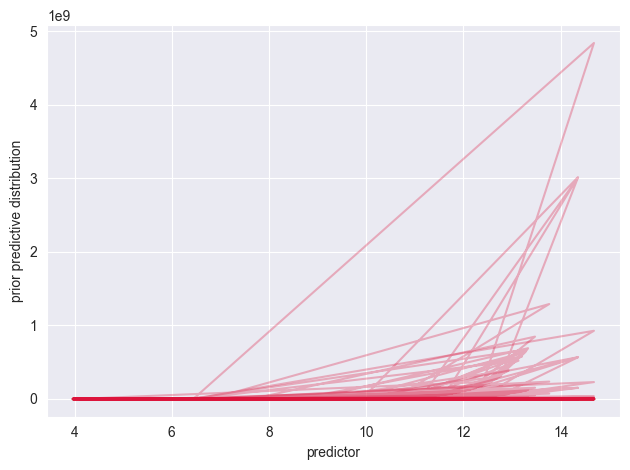

In [18]:
# Prior predictive check
y_flat_prior = np.exp(flat_prior.prior["intercept"] + (flat_prior.prior["slope"] * xarray))
y_flat_prior = y_flat_prior.stack(sample=("chain", "draw"))

_ = plt.plot(xarray, y_flat_prior, color = "crimson", alpha = 0.3)
_ = plt.xlabel("predictor")
_ = plt.ylabel("prior predictive distribution")

The flat prior allows for a very lax range of predictions.

In [19]:
# Draw posterior samples
with flat_model:
    flat_posterior = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


In [20]:
# Sample from posterior
with flat_model:
    pm.sample_posterior_predictive(flat_posterior, extend_inferencedata = True, random_seed = rng)

Sampling: [outcome]


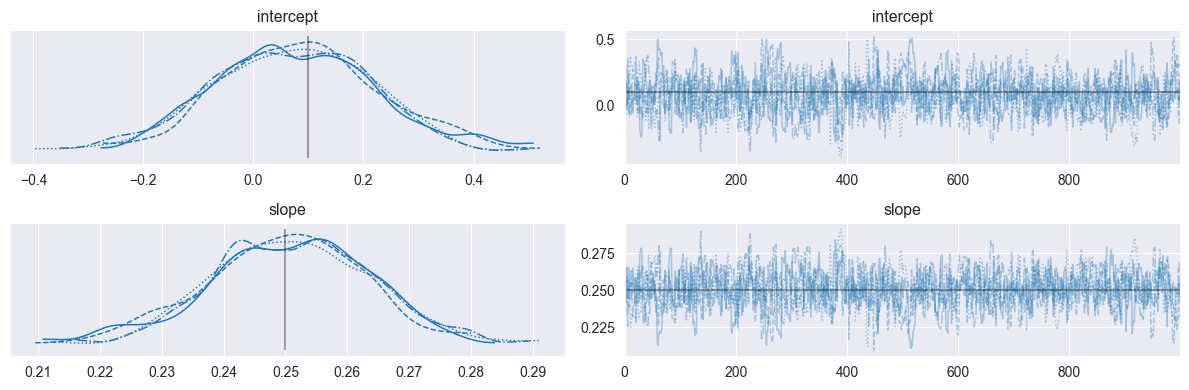

In [21]:
# Plot distribution & sampling chains
_ = az.plot_trace(
    flat_posterior,
    lines = (
        ("intercept", {}, true_intercept),
        ("slope", {}, true_slope)
    )
)

Better intercept & slope estimates compared to OLS even with flat prior.

In [22]:
# Simulate fitted regression lines
flat_posterior.posterior["fitted"] = np.exp(flat_posterior.posterior["intercept"] + flat_posterior.posterior["slope"] * xarray)

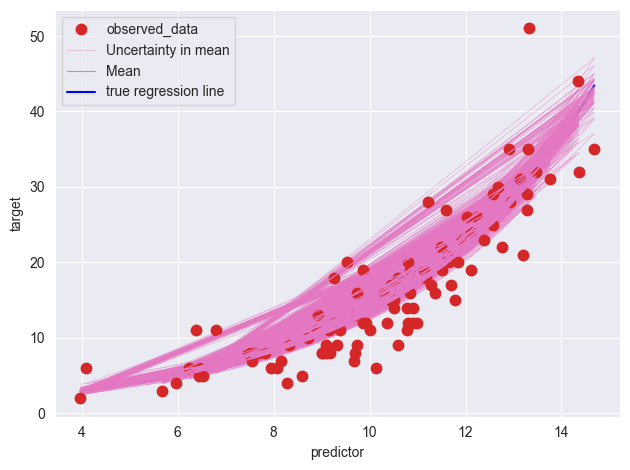

In [23]:
# Plot regression lines
_ = az.plot_lm(
    idata = flat_posterior, 
    x = x, # Predictor values
    y = y, # Real target
    y_model = "fitted" # Fitted regression lines
)
_ = sns.lineplot(
    x = x, 
    y = true_line, 
    label = "true regression line", color = "blue")
_ = plt.xlabel("predictor")
_ = plt.ylabel("target")

C:\Users\PC\Documents\WorkLocal\DataScience\GitHub\BayesianModelingExperiments\venv\lib\site-packages\xarray\core\utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


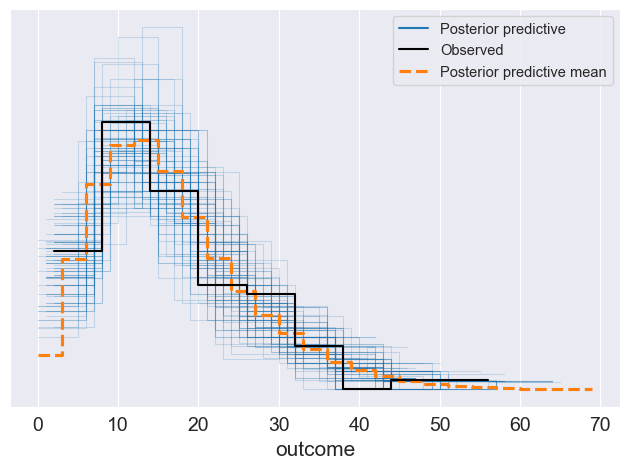

In [24]:
# Plot posterior distribution
_ = az.plot_ppc(flat_posterior, num_pp_samples = 100)

Fitted relationship & posterior predictive distribution is pretty decent for flat priors.

## Weakly Informative Prior

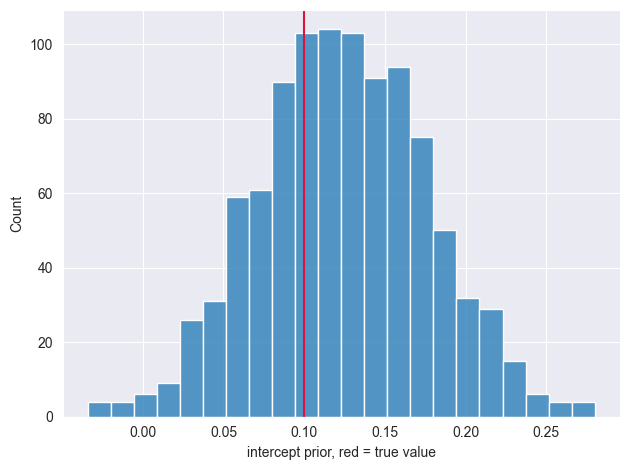

In [25]:
# Tune the intercept prior
prior_intercept_mu = 0.125
prior_intercept_sd = 0.05
_ = sns.histplot(rng.normal(prior_intercept_mu, prior_intercept_sd, size = 1000))
_ = plt.axvline(true_intercept, c = "crimson")
_ = plt.xlabel("intercept prior, red = true value")

Roughly allows for a zero to 0.3 intercept.

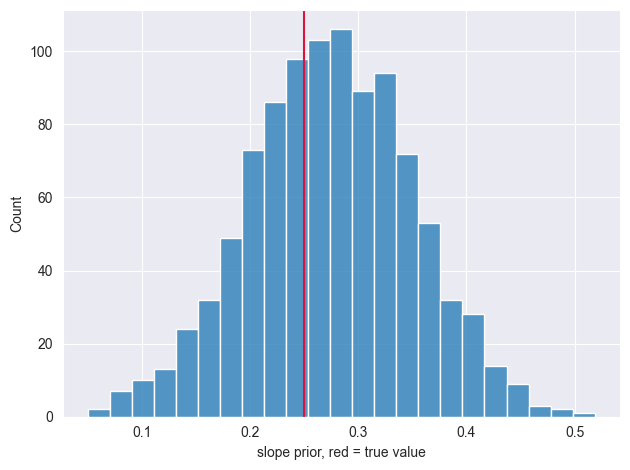

In [26]:
# Tune the slope prior
prior_slope_mu = 0.275
prior_slope_sd = 0.075
_ = sns.histplot(rng.normal(prior_slope_mu, prior_slope_sd, size = 1000))
_ = plt.axvline(true_slope, c = "crimson")
_ = plt.xlabel("slope prior, red = true value")

Roughly allows for a 0.1 to 0.5 slope, where the relationship becomes very weak / strong.

Since the intercept & slope are in units of log(y), informative priors need to be very precise.

In [27]:
# Create model
informative_model = pm.Model()

In [28]:
# Define priors & likelihood
with informative_model:

    # Informative priors for all parameters
    intercept = pm.Normal("intercept", mu = prior_intercept_mu, sigma = prior_intercept_sd)
    slope = pm.Normal("slope", mu = prior_slope_mu, sigma = prior_slope_sd)

    # Expected value & link
    mean = pm.math.exp(intercept + slope * x)

    # Likelihood
    likelihood = pm.Poisson("outcome", mu = mean, observed = y)

In [29]:
# Sample from the prior
with informative_model:
    informative_prior = pm.sample_prior_predictive(
        samples = n_obs,
        var_names = ["intercept", "slope"],
        random_seed = rng)

Sampling: [intercept, slope]


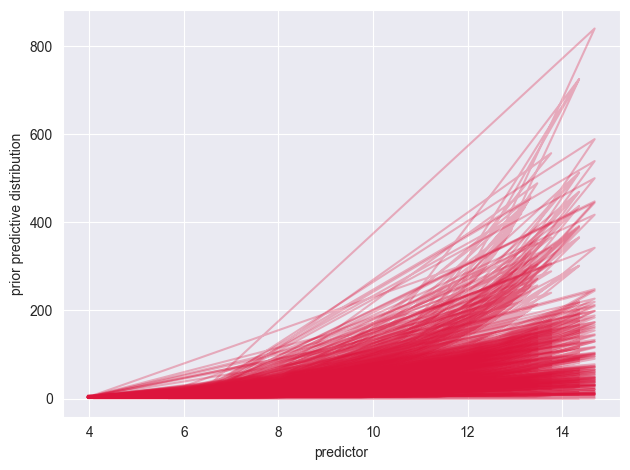

In [30]:
# Prior predictive check
y_informative_prior = np.exp(informative_prior.prior["intercept"] + (informative_prior.prior["slope"] * xarray))
y_informative_prior = y_informative_prior.stack(sample=("chain", "draw"))

_ = plt.plot(xarray, y_informative_prior, color = "crimson", alpha = 0.3)
_ = plt.xlabel("predictor")
_ = plt.ylabel("prior predictive distribution")

In [31]:
# Draw posterior samples
with informative_model:
    informative_posterior = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


In [32]:
# Sample from posterior
with informative_model:
    pm.sample_posterior_predictive(informative_posterior, extend_inferencedata = True, random_seed = rng)

Sampling: [outcome]


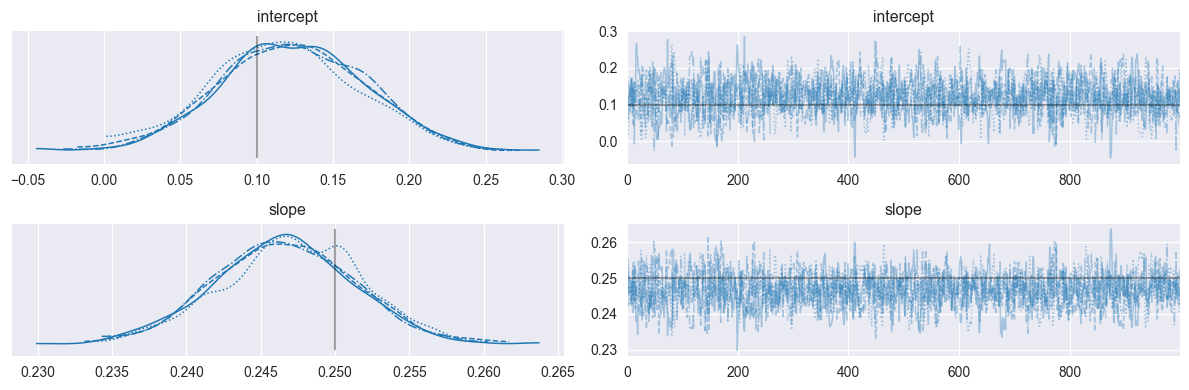

In [33]:
# Plot distribution & sampling chains
_ = az.plot_trace(
    informative_posterior,
    lines = (
        ("intercept", {}, true_intercept),
        ("slope", {}, true_slope)
    )
)

Better intercept & slope estimates, but still not too good.

In [34]:
# Simulate fitted regression lines
informative_posterior.posterior["fitted"] = np.exp(informative_posterior.posterior["intercept"] + informative_posterior.posterior["slope"] * xarray)

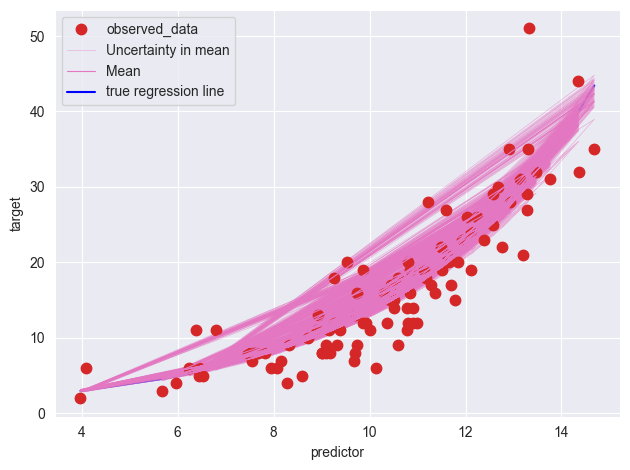

In [35]:
# Plot regression lines
_ = az.plot_lm(
    idata = informative_posterior, 
    x = x, # Predictor values
    y = y, # Real target
    y_model = "fitted" # Fitted regression lines
)
_ = sns.lineplot(
    x = x, 
    y = true_line, 
    label = "true regression line", color = "blue")
_ = plt.xlabel("predictor")
_ = plt.ylabel("target")

C:\Users\PC\Documents\WorkLocal\DataScience\GitHub\BayesianModelingExperiments\venv\lib\site-packages\xarray\core\utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


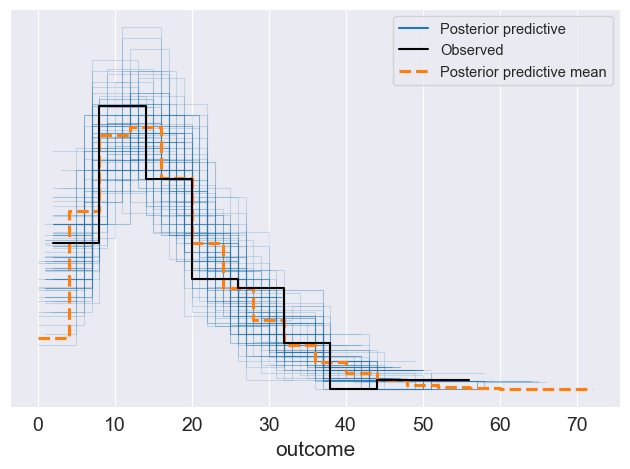

In [36]:
# Plot posterior distribution
_ = az.plot_ppc(informative_posterior, num_pp_samples = 100)

A supposedly "informative" prior is not much better than a flat prior in the log scale.